
# TP Image classification of MNIST (reduced)
## using correlation filters, kNN and/or logistic regression
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   
Polytech SI3  2022-2023

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

from tqdm import tqdm

import pickle

## Data loading

Before executing the next cell, you need to have downloaded the files in the current directory or to change the paths in the next cell.

In [2]:
import pickle
with open('redMNIST-x-train.bin', 'rb') as input:
    xTrain = pickle.load(input)
with open('redMNIST-x-test.bin', 'rb') as input:
    xTest = pickle.load(input)
with open('redMNIST-y-test.bin', 'rb') as input:
    yTest = pickle.load(input)
with open('redMNIST-y-train.bin', 'rb') as input:
    yTrain = pickle.load(input)
yTrain = np.array(yTrain)
yTest = np.array(yTest)

**Question 1:** What are the dimensions of train data and test data?

In [3]:

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(2000, 28, 28)
(1000, 28, 28)
(2000,)
(1000,)


**Question 2:** How many classes?

In [4]:
# Il y a 10 classes
print(np.unique(yTrain))

[0 1 2 3 4 5 6 7 8 9]


**Question 3:** What are the minimal and maximal values of pixels in those images?

In [5]:
print(np.min(xTrain), np.max(xTrain))

0.0 1.0


Let's visualize an image from the training dataset:

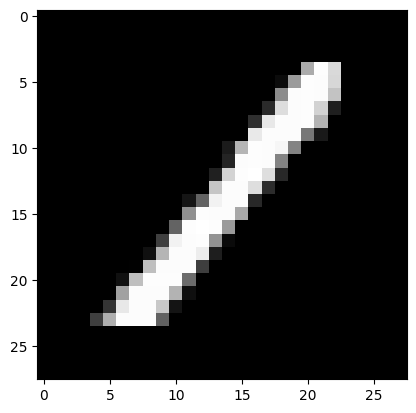

In [6]:
import random
n = random.randrange(0,len(yTrain))
plt.imshow(xTrain[n], cmap=plt.cm.gray)

## Baseline: raw MNIST data without correlations

We first need to flatten the data:

In [7]:
x_train = xTrain.reshape(len(yTrain), 784)
x_test = xTest.reshape(len(yTest), 784)
y_train = yTrain
y_test = yTest

The baseline is obtained using a kNN classification with k=10 on the raw MNIST dataset. 

**Question 4:** Compute the evaluation metrics (accuracy, F1 score and confusion matrix) using the test set. Publish the accuracy in slack as the variable <font color='red'>rawKnn10</font>.

100%|██████████| 1000/1000 [00:06<00:00, 152.42it/s]


Accuracy: 0.866
F1-score: 0.8651844387386249


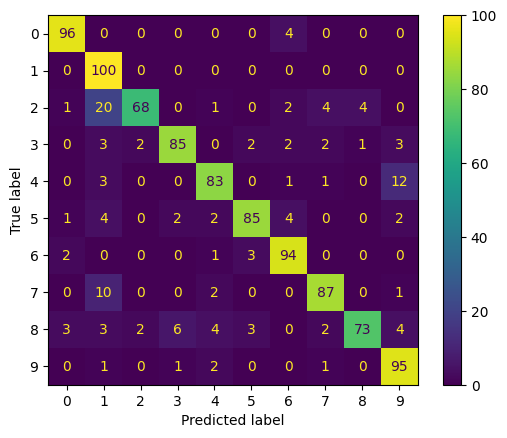

In [8]:
from sklearn.metrics import confusion_matrix

def vote_knn(xtrain, ytrain, nKnn, newData):
    distance_list = [0 for i in range(len(xtrain))]

    for i in range(len(xtrain)):
        distance_list[i] = np.linalg.norm(
            xtrain[i] - newData)

    sorted_arr_indices = np.argsort(distance_list)

    nei = [sorted_arr_indices[i] for i in range(nKnn)]

    yn = [ytrain[nei[i]] for i in range(nKnn)]

    classes_occ = [0 for i in range(10)]
    for c in yn:
        classes_occ[int(c)] += 1

    classe = np.argmax(classes_occ)

    return classe

y_pred = [vote_knn(x_train, y_train, 10, x) for x in tqdm(x_test)]

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1}')

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=range(10)).plot()

plt.show()

**Question 4.5:** Find the best k value for the previous question. Publish the best k value as <font color='red'>rawKnnBestK</font> and the best accuracy as <font color='red'>rawKnnBestAcc</font>.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

def find_best_k(xtrain, ytrain, xtest, ytest, kmin, kmax):
    best_k = 0
    best_acc = 0
    for k in tqdm(range(kmin, kmax+1)):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(xtrain, ytrain)
        y_pred = knn.predict(xtest)
        acc = accuracy_score(ytest, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_k = k
    return best_k, best_acc

best_k, best_acc = find_best_k(x_train, y_train, x_test, y_test, 1, 10)

print(f'Best k: {best_k}')
print(f'Best accuracy: {best_acc}')

100%|██████████| 10/10 [00:00<00:00, 15.78it/s]

Best k: 3
Best accuracy: 0.88


**Question 5:** Learn a logistic regression on the train set and compute the metrics on the test set. Be aware that the default maximal number of iterations may need to be adapted. Publish the accuracy as <font color='red'>rawLogReg</font>.

In [10]:
def learn_logistic_regression(xtrain, ytrain, xtest, ytest):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred, average='weighted')
    return accuracy, f1

accuracy, f1 = learn_logistic_regression(x_train, y_train, x_test, y_test)
print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')


Accuracy: 0.861
F1-score: 0.8608833367242845


**Question 6:** Up to now, what is the best method?

In [11]:
# The best method is the second one

## Correlation kernels and functions

We propose 2 sets of kernel denoted by variables 'c3x3' and 'c5x5'. Feel free to imagine other sets of kernels.

In [12]:
# 4 kernels of dim 3x4
c0 = np.array([[-1.1, -1.49, -0.72],
 [-0.78,  0.8,   0.92],
 [ 1.58,  0.73,  0.62]])
c1 = np.array([[ 1.22, 0.97,  0.39],
 [-0.62,  0.92,  1.42],
 [-1.55, -1.65, -0.51]])
c2 = np.array([[ 0.48, 1.32, -1.08],
 [ 0.98,  0.69, -1.99],
 [ 1.35, -0.24, -1.59]])
c3 = np.array([[-0.38,  1.03,  1.28],
 [-1.37,  0.18,  0.24],
 [-0.1,   0.9,   1.29]])
c3x3 = np.array([c0,c1,c2,c3])

In [13]:
# 8 kernels of dim 5x5
c0 = np.array([[-0.05, -0.13,  0.02,  0.12,  0.12],
 [-0.23,  0.45,  0.86,  0.79,  0.35],
 [-0.04,  0.35,  0.58,  0.41, -0.4 ],
 [-0.09,  0.12,  0.2 ,  0.22, -0.6 ],
 [ 0.31,  0.07, -0.01, -0.38, -0.19]])
c1 = np.array([[ 0.27,  0.1 ,  0.36,  0.29,  0.65],
 [ 0.34,  0.54,  0.62,  0.43,  0.76],
 [ 0.66,  0.64,  0.57,  0.15, -0.06],
 [ 0.25,  0.29, -0.01, -0.14, -0.84],
 [-1.23, -1.59, -1.78, -1.04, -1.07]])
c2 = np.array([[-0.66, -0.87, -1.09, -1.25, -0.44],
 [-0.01,  0.18, -0.06,  0.11,  0.13],
 [ 0.39,  0.5 ,  0.51,  0.42,  0.32],
 [ 0.32,  0.49,  0.3 ,  0.35,  0.41],
 [ 0.64,  0.7 ,  0.22, -0.05,  0.28]])
c3 = np.array([[ 1.01,  0.07,  0.16, -0.42, -0.75],
 [ 0.23,  0.08,  0.3 ,  0.11, -0.14],
 [-0.69,  0.02,  0.19,  0.35,  0.16],
 [-0.74,  0.45,  0.61,  0.26, -0.04],
 [ 0.1,   0.6 ,  0.15, -0.37, -0.84]])
c4 = np.array([[ 0.25,  0.34,  0.29, -0.42, -0.69],
 [ 0.5,   0.31,  0.45, -0.34, -0.31],
 [ 0.66,  0.6 ,  0.28, -0.62, -0.82],
 [ 0.37,  0.73, -0.05, -0.58, -0.87],
 [ 0.59,  0.43,  0.02, -0.62, -0.41]])
c5 = np.array([[ 0.06, -0.48, -0.43, -0.93, -0.19],
 [ 0.57,  0.63,  0.5 ,  0.02, -0.35],
 [ 0.5 ,  0.92,  1.03,  0.33, -0.58],
 [-0.55,  0.11,  0.77,  0.74,  0.21],
 [-1.44, -1.08, -0.54,  0.01,  0.27]])
c6 = np.array([[ 0.4 ,  0.62,  0.73,  0.58,  0.43],
 [-0.02,  0.47,  0.99,  0.55,  0.65],
 [-1.01, -0.83,  0.07,  0.51,  0.47],
 [-1.01, -1.16, -0.8 , -0.06,  0.5 ],
 [-0.06, -0.24, -0.96, -0.7 , -0.08]])
c7 = np.array([[-0.8 , -0.25, -0.02,  0.36,  0.4 ],
 [-1.43, -0.01,  0.04,  0.28,  0.63],
 [-1.3 ,  0.1 ,  0.61,  0.58,  0.4 ],
 [-1.28,  0.23,  0.46,  0.34,  0.35],
 [-0.57,  0.44,  0.51,  0.34, -0.  ]])
c5x5 = np.array([c0,c1,c2,c3,c4,c5,c6,c7])

In [14]:
#filters display
def displayFilters(filtres):
    nbFiltres, dimFiltres = filtres.shape[:2]

    fig, axes = plt.subplots(nrows=1, ncols=nbFiltres,figsize=(nbFiltres*4,6))
    ax = axes.ravel()
    for k in range(nbFiltres):
        ax[k].matshow(filtres[k], cmap = plt.cm.gray)
        poids = filtres[k]
        poids = np.round(poids*100)/100
   
        for i in range(dimFiltres):
            for j in range(dimFiltres):
                if filtres[k,i,j] < 0:
                    text = ax[k].text(j, i, poids[i,j], ha="center", va="center", color="w")
                else:
                    text = ax[k].text(j, i, poids[i,j], ha="center", va="center", color="k")


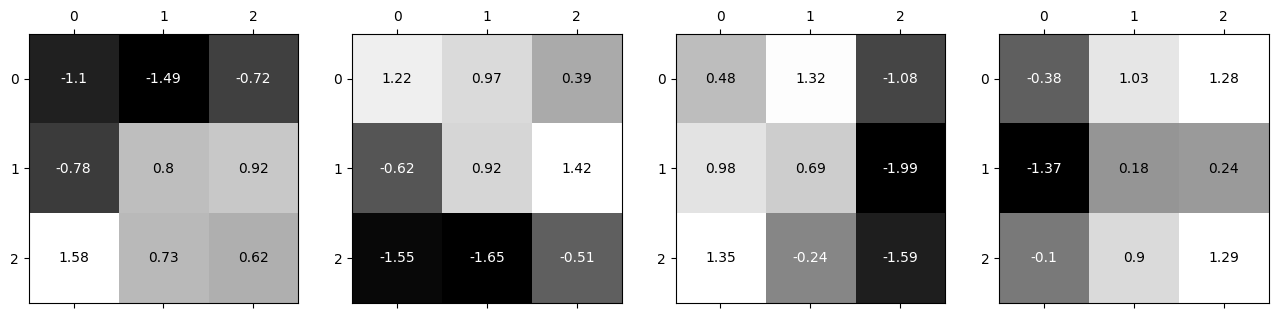

In [15]:
displayFilters(c3x3)

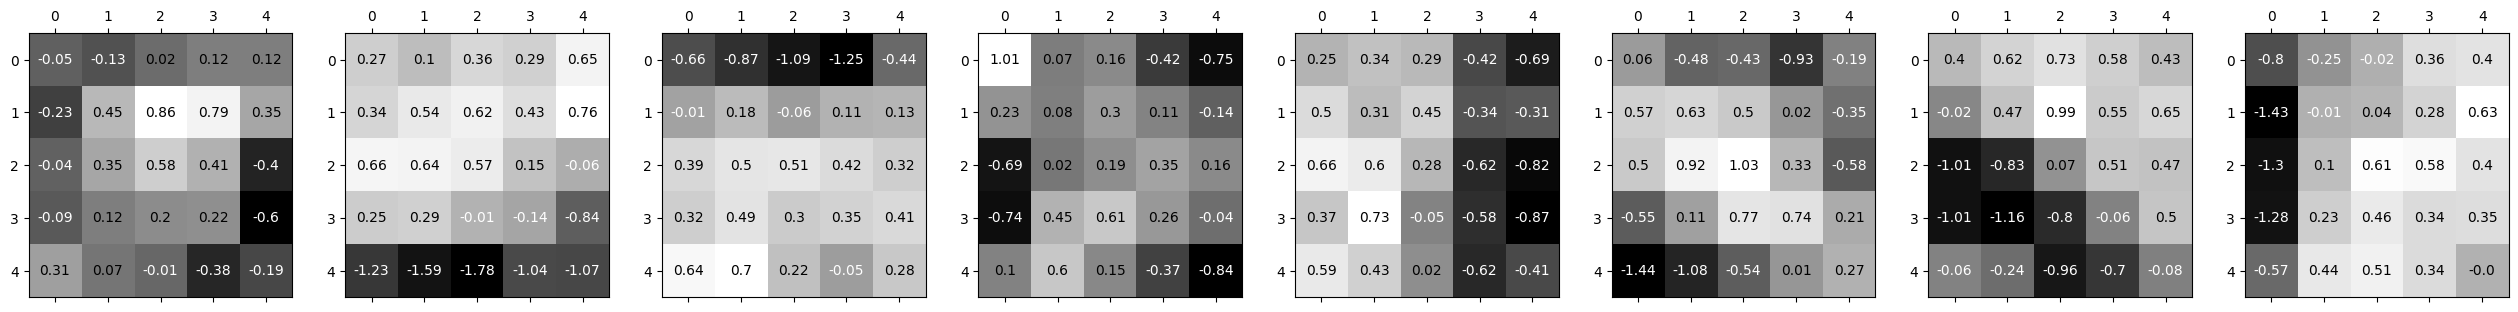

In [16]:
displayFilters(c5x5)

**Question 7:** Copy/paste here your best version of a function for correlation without normalisation.

In [17]:
def crossCorrelation(im, mo):
    res = np.zeros((im.shape[0]-mo.shape[0]+1,im.shape[0]-mo.shape[0]+1))
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i,j] = np.sum(im[i:i+mo.shape[0],j:j+mo.shape[0]]*mo)
    return res


**Question 8:** Observe the results of correlation using a set of filters on a single image from the dataset.

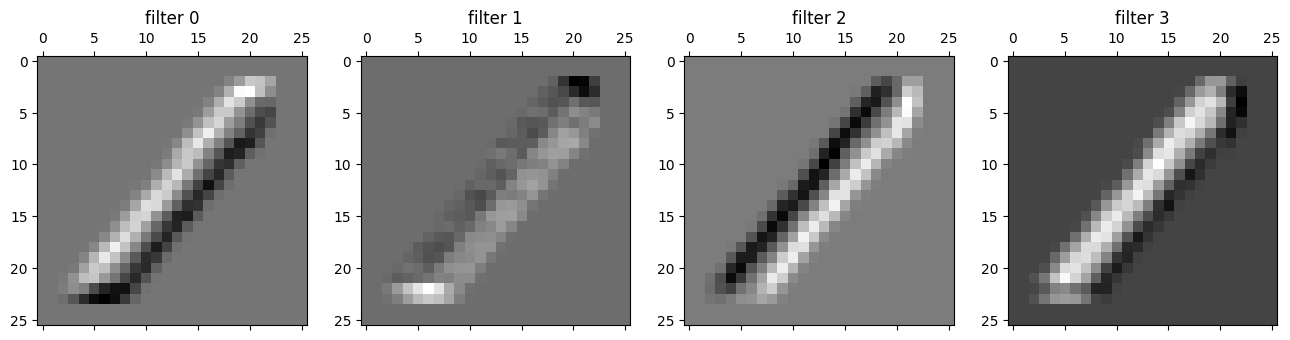

In [18]:
im = xTrain[n]
filtres = c3x3

nbFiltres, dimFiltres = filtres.shape[:2]
fig, axes = plt.subplots(nrows=1, ncols=nbFiltres,figsize=(nbFiltres*4,6))
ax = axes.ravel()
for k in range(nbFiltres):
    res = crossCorrelation(im, filtres[k])
    ax[k].matshow(res, cmap = plt.cm.gray)
    ax[k].set_title("filter " + str(k))
plt.show()

**Question 9:** Similar question but adding a new parameter: the stride. Test also on a single image as you did in the previous questio²n.

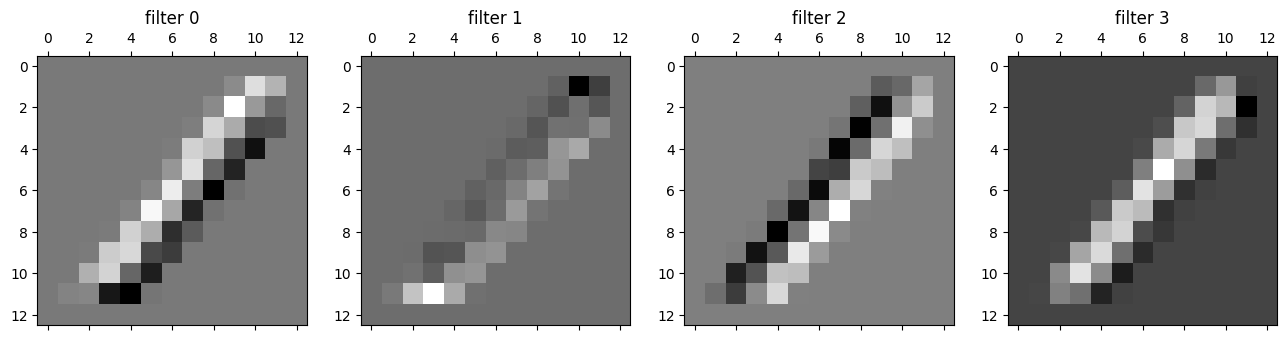

In [19]:
def crossCorrelationStride(im, mo, stride):
    res = np.zeros(((im.shape[0]-mo.shape[0])//stride+1,(im.shape[0]-mo.shape[0])//stride+1))
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i,j] = np.sum(im[i*stride:i*stride+mo.shape[0],j*stride:j*stride+mo.shape[0]]*mo)
    return res

im = xTrain[n]
filtres = c3x3

nbFiltres, dimFiltres = filtres.shape[:2]
fig, axes = plt.subplots(nrows=1, ncols=nbFiltres,figsize=(nbFiltres*4,6))
ax = axes.ravel()
for k in range(nbFiltres):
    res = crossCorrelationStride(im, filtres[k], 2)
    ax[k].matshow(res, cmap = plt.cm.gray)
    ax[k].set_title("filter " + str(k))
plt.show()

**Question 10:** Write a fonction that will compute all the correlations on a dataset x using a list of filters c with a stride similar on vertical and horizontal. We assume that all filters are squared filters with odd dimensions. The result is a transformed dataset with the same number of data. Each data is a vector containing all results of correlations.

In [20]:
def passeLesFiltres(x,c,stride):
    nbFiltres, dimFiltres = c.shape[:2]
    dimData = x.shape[1]
    dimRes = (dimData-dimFiltres)//stride+1
    res = np.zeros((x.shape[0],nbFiltres,dimRes,dimRes))
    for i in tqdm(range(x.shape[0])):
        for j in range(nbFiltres):
            res[i,j] = crossCorrelationStride(x[i],c[j],stride)
    return res

**Question 11:** Apply the previous function to the train and test dataset using the set of filters c3x3 and a stride of 3. Print the shape of the results.

In [21]:
fftrain3 = passeLesFiltres(xTrain,c3x3,3)
fftest3 = passeLesFiltres(xTest,c3x3,3)

print(fftrain3.shape)
print(fftest3.shape)

100%|██████████| 1000/1000 [00:01<00:00, 648.83it/s]

(2000, 4, 9, 9)
(1000, 4, 9, 9)


**You know will use such transformed dataset in order to improve the classification results.**

## Improved classifications

Using the metrics computed on the test set, try different combinations:
- kNN (which k) or Logistic Regression
- correlation filters: c3x3, c5x5 or other filters from your imagination
- normalisation or not for the correlation
- values of strides
- removing negative values after the correlation operation
Or any other idea that you can discuss with your teachers (or in the slack channel of the course). 

Each time you obtain a better accuracy than in the previous questions, publish it in slack.

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Define the hyperparameters to test
k_values = [3, 5, 7, 9]
filters = [c3x3, c5x5]
normalize_values = [True, False]
stride_values = [1, 2, 3]
remove_negative_values = [True, False]

# Initialize the best score
best_score = 0
best_params = {}

# Perform grid search
for k in k_values:
    for filter in filters:
        for normalize in normalize_values:
            for stride in stride_values:
                for remove_negative in remove_negative_values:
                    # Apply the filters
                    fftrain_filtered = passeLesFiltres(xTrain, filter, stride)
                    fftest_filtered = passeLesFiltres(xTest, filter, stride)

                    # Normalize if specified
                    if normalize:
                        scaler = MinMaxScaler()
                        fftrain_normalized = scaler.fit_transform(fftrain_filtered.reshape(fftrain_filtered.shape[0], -1))
                        fftest_normalized = scaler.transform(fftest_filtered.reshape(fftest_filtered.shape[0], -1))
                    else:
                        fftrain_normalized = fftrain_filtered.reshape(fftrain_filtered.shape[0], -1)
                        fftest_normalized = fftest_filtered.reshape(fftest_filtered.shape[0], -1)
                    
                    # Remove negative values if specified
                    if remove_negative:
                        fftrain_normalized = np.clip(fftrain_normalized, a_min=0, a_max=None)
                        fftest_normalized = np.clip(fftest_normalized, a_min=0, a_max=None)

                    # Fit and score the kNN classifier
                    knn = KNeighborsClassifier(n_neighbors=k)
                    knn.fit(fftrain_normalized, yTrain)
                    y_pred = knn.predict(fftest_normalized)
                    accuracy = accuracy_score(yTest, y_pred)
                    f1 = f1_score(yTest, y_pred, average='weighted')
                    
                    # Update the best score and parameters
                    if accuracy > best_score:
                        best_score = accuracy
                        best_params = {
                            "k": k,
                            "filter": filter,
                            "normalize": normalize,
                            "stride": stride,
                            "remove_negative": remove_negative
                        }

# Print the best score and parameters
print("Best Score: ", best_score)
print("Best Parameters: ", best_params)


100%|██████████| 1000/1000 [00:02<00:00, 423.63it/s]

Best Score:  0.897
Best Parameters:  {'k': 5, 'filter': array([[[-0.05, -0.13,  0.02,  0.12,  0.12],
        [-0.23,  0.45,  0.86,  0.79,  0.35],
        [-0.04,  0.35,  0.58,  0.41, -0.4 ],
        [-0.09,  0.12,  0.2 ,  0.22, -0.6 ],
        [ 0.31,  0.07, -0.01, -0.38, -0.19]],

       [[ 0.27,  0.1 ,  0.36,  0.29,  0.65],
        [ 0.34,  0.54,  0.62,  0.43,  0.76],
        [ 0.66,  0.64,  0.57,  0.15, -0.06],
        [ 0.25,  0.29, -0.01, -0.14, -0.84],
        [-1.23, -1.59, -1.78, -1.04, -1.07]],

       [[-0.66, -0.87, -1.09, -1.25, -0.44],
        [-0.01,  0.18, -0.06,  0.11,  0.13],
        [ 0.39,  0.5 ,  0.51,  0.42,  0.32],
        [ 0.32,  0.49,  0.3 ,  0.35,  0.41],
        [ 0.64,  0.7 ,  0.22, -0.05,  0.28]],

       [[ 1.01,  0.07,  0.16, -0.42, -0.75],
        [ 0.23,  0.08,  0.3 ,  0.11, -0.14],
        [-0.69,  0.02,  0.19,  0.35,  0.16],
        [-0.74,  0.45,  0.61,  0.26, -0.04],
        [ 0.1 ,  0.6 ,  0.15, -0.37, -0.84]],

       [[ 0.25,  0.34,  0.29, -0.42,

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Preprocessing: scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Try a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_scaled, y_train)
y_pred_rf = rf.predict(x_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

# Try a Support Vector Machine
svm = SVC(kernel='rbf', random_state=42)
svm.fit(x_train_scaled, y_train)
y_pred_svm = svm.predict(x_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm}')

# Try an ensemble of kNN, Logistic Regression, Random Forest, and SVM
from sklearn.ensemble import VotingClassifier

knn = KNeighborsClassifier(n_neighbors=best_k)
lr = LogisticRegression(max_iter=1000)

voting_clf = VotingClassifier(
    estimators=[('knn', knn), ('lr', lr), ('rf', rf), ('svm', svm)],
    voting='hard')

voting_clf.fit(x_train_scaled, y_train)

y_pred_voting = voting_clf.predict(x_test_scaled)

accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Accuracy: {accuracy_voting}')


Random Forest Accuracy: 0.894
SVM Accuracy: 0.877
Voting Classifier Accuracy: 0.896
